# Film Plot Generator
### Kwame V. Taylor

This project aims to generate a movie plot description based on seed input, such as director and genre. Data scraped from Wikipedia and found on Kaggle.

## Set up environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
import nltk
#nltk.download()

import unicodedata
import re
import json

import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

from preprocessing import plots_split

# default viz size settings
plt.rc('figure', figsize=(9, 7))
plt.rc('font', size=15)

In [2]:
# show nltk methods
dir(nltk)

['AbstractLazySequence',
 'AffixTagger',
 'AlignedSent',
 'Alignment',
 'AnnotationTask',
 'ApplicationExpression',
 'Assignment',
 'BigramAssocMeasures',
 'BigramCollocationFinder',
 'BigramTagger',
 'BinaryMaxentFeatureEncoding',
 'BlanklineTokenizer',
 'BllipParser',
 'BottomUpChartParser',
 'BottomUpLeftCornerChartParser',
 'BottomUpProbabilisticChartParser',
 'Boxer',
 'BrillTagger',
 'BrillTaggerTrainer',
 'CFG',
 'CRFTagger',
 'CfgReadingCommand',
 'ChartParser',
 'ChunkParserI',
 'ChunkScore',
 'Cistem',
 'ClassifierBasedPOSTagger',
 'ClassifierBasedTagger',
 'ClassifierI',
 'ConcordanceIndex',
 'ConditionalExponentialClassifier',
 'ConditionalFreqDist',
 'ConditionalProbDist',
 'ConditionalProbDistI',
 'ConfusionMatrix',
 'ContextIndex',
 'ContextTagger',
 'ContingencyMeasures',
 'CoreNLPDependencyParser',
 'CoreNLPParser',
 'Counter',
 'CrossValidationProbDist',
 'DRS',
 'DecisionTreeClassifier',
 'DefaultTagger',
 'DependencyEvaluator',
 'DependencyGrammar',
 'DependencyGrap

In [3]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)

## Acquire data

In [4]:
df = pd.read_csv('plots.csv')
df.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


## Narrow project scope

To narrow the project's scope, I'm going to focus on just American cinema.

In [5]:
df = df[df['Origin/Ethnicity'] == 'American']

## Summarize the data

In [6]:
# summarize data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17377 entries, 0 to 17376
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      17377 non-null  int64 
 1   Title             17377 non-null  object
 2   Origin/Ethnicity  17377 non-null  object
 3   Director          17377 non-null  object
 4   Cast              17060 non-null  object
 5   Genre             17377 non-null  object
 6   Wiki Page         17377 non-null  object
 7   Plot              17377 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.2+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbac0ae0e50>]],
      dtype=object)

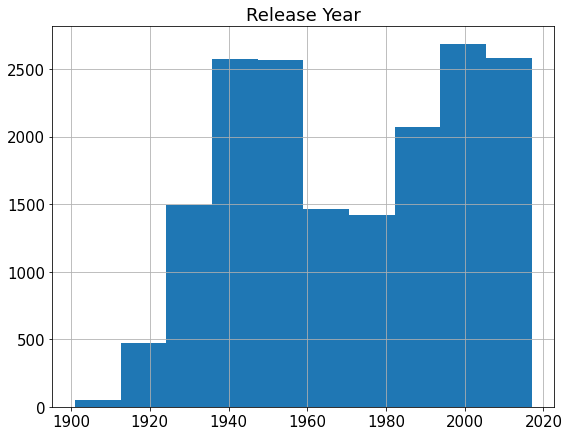

In [7]:
df.hist()

## Prepare the data

In [8]:
# check for nulls
df.isna().sum()

Release Year          0
Title                 0
Origin/Ethnicity      0
Director              0
Cast                317
Genre                 0
Wiki Page             0
Plot                  0
dtype: int64

In [9]:
df[df.isna().any(axis=1)]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....
10,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,NaN,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...


I don't see too many noteable films here so I might drop rows with NaN for now. I'll marinate some thoughts on how I eventually want to handle all of the NaNs and 'Unknown's.

In [10]:
# drop NaNs
df = df.dropna()

In [11]:
# drop duplicates
df = df.drop_duplicates()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbab805b6d0>]],
      dtype=object)

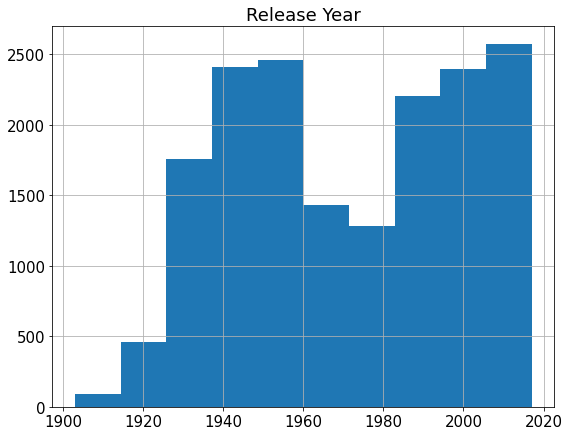

In [12]:
# check distribution of cont. variable(s) again
df.hist()

In [13]:
# fix for error
# "ValueError: The least populated class in y has only 1 member,
# which is too few. The minimum number of groups for any class
# cannot be less than 2."

df['Release Year'].value_counts()

df = df.drop(df[df['Release Year'] < 1904].index)
df['Release Year'].value_counts()

2006    326
2013    313
1996    287
1951    266
1997    261
2012    259
2007    259
1940    255
1957    252
1941    249
1950    247
1956    243
1995    240
1953    238
1939    236
1942    234
1944    230
1952    222
1988    222
1994    221
1955    220
1943    219
1948    219
1987    215
1989    215
1998    214
1990    214
2017    213
1949    212
1946    212
2009    208
2002    204
2005    204
2004    203
1945    203
1958    203
2001    202
1932    199
2003    199
1954    198
1947    197
1934    195
1935    195
1999    193
2010    192
1931    191
2000    190
2014    188
2008    187
2011    182
1933    181
1991    177
1993    177
1992    177
1930    175
1937    170
1985    166
1986    162
1959    155
1938    154
1936    146
1984    145
1971    131
1982    129
1964    127
1980    126
1961    125
2016    125
1929    124
1960    123
1968    123
1972    122
1962    120
1981    120
1973    120
1966    118
1963    118
2015    117
1977    116
1983    115
1978    114
1979    114
1967    113
1970

In [14]:
# split the data
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = plots_split(df, 'Plot')
train.head(3)

Shape of train: (11940, 7) | Shape of validate: (2560, 7) | Shape of test: (2559, 7)
Percent train: 70.0        | Percent validate: 15.0       | Percent test: 15.0


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
15234,2007,Hostel: Part II,American,Eli Roth,"Lauren German, Roger Bart, Bijou Phillips, Hea...",horror,https://en.wikipedia.org/wiki/Hostel:_Part_II,"Shortly after the events of Hostel, Paxton is ..."
1154,1931,Little Caesar,American,Mervyn LeRoy,"Edward G. Robinson, Douglas Fairbanks, Jr., Gl...","drama, crime",https://en.wikipedia.org/wiki/Little_Caesar_(f...,"Small-time criminals Caesar Enrico ""Rico"" Band..."
11528,1990,Spirit of '76,American,Lucas Reiner,"Carl Reiner, Rob Reiner",comedy,https://en.wikipedia.org/wiki/Spirit_of_%2776_...,"By the year 2176, a magnetic storm has degauss..."


## Exploratory data analysis

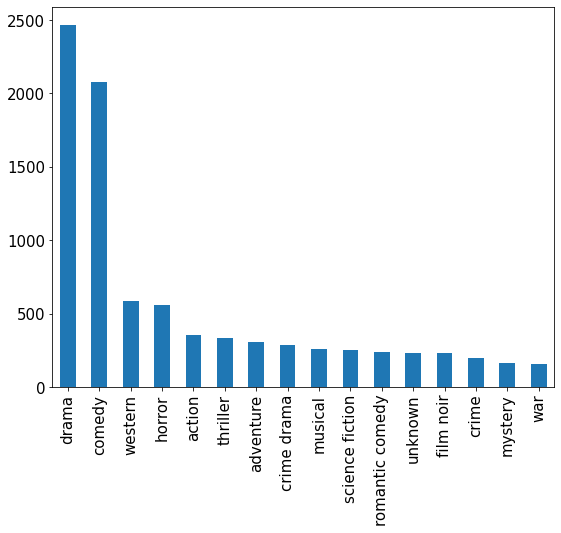

In [15]:
train['Genre'].value_counts().head(16).plot.bar()

In [16]:
#romance = 
train[train['Genre'] == 'romance']

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
13630,2000,Chocolat,American,Lasse Hallström,"Juliette Binoche, Judi Dench, Alfred Molina, L...",romance,https://en.wikipedia.org/wiki/Chocolat_(2000_f...,An unnamed female storyteller narrates the sto...
9413,1977,Roseland,American,James Ivory,"Teresa Wright, Geraldine Chaplin, Christopher ...",romance,https://en.wikipedia.org/wiki/Roseland_(film),"At Roseland, an older lady, May (Wright), with..."
11910,1992,That Night,American,Craig Bolotin,"C. Thomas Howell, Juliette Lewis, Eliza Dushku",romance,https://en.wikipedia.org/wiki/That_Night,"In 1961 Long Island, Alice Bloom (Eliza Dushku..."
3834,1944,Johnny Doesn't Live Here Anymore,American,Joe May,"Simone Simon, James Ellison",romance,https://en.wikipedia.org/wiki/Johnny_Doesn%27t...,A young defense worker Kathie Aumont (Simone S...
14519,2004,P.S.,American,Dylan Kidd,"Laura Linney, Topher Grace, Gabriel Byrne",romance,https://en.wikipedia.org/wiki/P.S._(film),Thirty-nine-year old divorcée Louise Harringto...
13816,2001,Captain Corelli's Mandolin,American,John Madden,"Nicolas Cage, Penélope Cruz",romance,https://en.wikipedia.org/wiki/Captain_Corelli%...,Greece's Ionian Islands are invaded by the Ita...
14281,2003,The Human Stain,American,Robert Benton,"Anthony Hopkins, Nicole Kidman",romance,https://en.wikipedia.org/wiki/The_Human_Stain_...,"In the late 1990s, writer Nathan Zuckerman (Ga..."
10120,1983,"Reuben, Reuben",American,Robert Ellis Miller,"Tom Conti, Kelly McGillis",romance,"https://en.wikipedia.org/wiki/Reuben,_Reuben",Gowan McGland (Tom Conti) is a creatively bloc...
1367,1932,No More Orchids,American,Walter Lang,"Carole Lombard, Lyle Talbot",romance,https://en.wikipedia.org/wiki/No_More_Orchids,The departure of an ocean liner is held up to ...
3827,1944,"In the Meantime, Darling",American,Otto Preminger,Jeanne Crain,romance,"https://en.wikipedia.org/wiki/In_the_Meantime,...","Due to limited wartime housing, Army lieutenan..."


In [17]:
train.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot'], dtype='object')